# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.base import TransformerMixin


# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print("the shape of azdias and the first 5 rows")

print(azdias.shape)
display(azdias.head(n=5))

#display(azdias.describe())



the shape of azdias and the first 5 rows
(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
print("the shape of feat_info and the first 5 rows")
print(feat_info.shape)
#feat_info.set_index('attribute', inplace=True)
display(feat_info.head(n=5))


the shape of feat_info and the first 5 rows
(85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,CAMEO_INTL_2015,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# list all the columns in the azdias

column_names = azdias.columns

print(column_names)

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [8]:
print('Number of missing values in each row')
original_missing_val = azdias.isnull().sum()
print(original_missing_val)


Number of missing values in each row
AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
   

In [9]:
print('Number of missing values in all the rows')
print(azdias.isnull().sum().sum())

Number of missing values in all the rows
4896838


In [10]:
# preocess missing_or_unknown column in the feat_info

char_to_eliminate = ['\[', '\]']

missing_value = feat_info ['missing_or_unknown'].replace(to_replace = char_to_eliminate, value = '', regex = True)

display(missing_value)

0       -1,0
1     -1,0,9
2       -1,0
3          0
4         -1
5         -1
6         -1
7         -1
8         -1
9         -1
10        -1
11         0
12          
13          
14      -1,0
15         0
16         0
17         0
18         0
19         0
20         0
21      -1,0
22      -1,0
23         0
24      -1,9
25      -1,9
26      -1,9
27      -1,9
28      -1,9
29      -1,9
       ...  
55        -1
56        -1
57      -1,X
58        XX
59     -1,XX
60        -1
61        -1
62        -1
63        -1
64      -1,0
65      -1,0
66        -1
67        -1
68        -1
69          
70      -1,0
71          
72          
73      -1,0
74          
75        -1
76        -1
77        -1
78        -1
79      -1,0
80        -1
81        -1
82      -1,9
83      -1,0
84      -1,9
Name: missing_or_unknown, Length: 85, dtype: object

In [11]:
# create a list of these unknown value to process it later by converting int numbers to float.

missing_val = []
# for the purpose to know exacly what values are considered unknown, also to build a big picturte of what I am doing
unique_list = []

for val in range(len(missing_value)):
    
    missing_val.append(missing_value[val].split(','))
    nn = missing_value[val].split(',')
    if nn not in unique_list: 
            unique_list.append(nn)

display(unique_list)

[['-1', '0'],
 ['-1', '0', '9'],
 ['0'],
 ['-1'],
 [''],
 ['-1', '9'],
 ['-1', 'X'],
 ['XX'],
 ['-1', 'XX']]

In [12]:
print(len(missing_val))

85


In [13]:
# conversting int values to float values because the population data has float numbers not int
#so I need to fix this issue inorder to replace these values with NaN

for i in range(len(missing_val)):
    for j in range(len(missing_val[i])):
        if (missing_val [i][j] == 'X' or missing_val [i][j] == 'XX' or missing_val [i][j] == '' ):
            pass
        else:
            missing_val [i][j] = float(missing_val [i][j])
display(missing_val)

[[-1.0, 0.0],
 [-1.0, 0.0, 9.0],
 [-1.0, 0.0],
 [0.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [0.0],
 [''],
 [''],
 [-1.0, 0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [-1.0, 0.0],
 [-1.0, 0.0],
 [0.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0],
 [-1.0],
 [-1.0, 0.0],
 [-1.0],
 [-1.0, 9.0],
 [0.0],
 [''],
 [''],
 [-1.0, 0.0],
 [-1.0],
 [-1.0, 0.0],
 [-1.0, 0.0],
 [0.0],
 [''],
 [-1.0, 0.0],
 [''],
 [0.0],
 [-1.0],
 [-1.0],
 [-1.0, 'X'],
 ['XX'],
 [-1.0, 'XX'],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0, 0.0],
 [-1.0, 0.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [''],
 [-1.0, 0.0],
 [''],
 [''],
 [-1.0, 0.0],
 [''],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0, 0.0],
 [-1.0],
 [-1.0],
 [-1.0, 9.0],
 [-1.0, 0.0],
 [-1.0, 9.0]]

In [14]:
#see the description before replacing the missing values 
display(azdias.describe())

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [15]:
# filling up the missing values with NaN

for i in range(len(missing_val)):
    
    azdias[feat_info.iloc[i]['attribute']].replace(to_replace = missing_val[i], value = np.NaN, regex = True, inplace = True)
    
display(azdias.head(n=15))

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [16]:
#see the description after replacing the missing values 
display(azdias.describe())

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,213718.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,1.675376,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,0.742250,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,2.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


In [17]:
# compare the previous missing_values with updated missing_values

after_missing_updated = azdias.isnull().sum()

col1= pd.Series(original_missing_val, name = "before updated")
col2 = pd.Series(after_missing_updated, name = "after updated")


concatenate_result = pd.concat([col1, col2], axis = 1)
print("The number of missing values before and after identifying the missing values and then converted them to NaN.")
print("")
print(concatenate_result)

The number of missing values before and after identifying the missing values and then converted them to NaN.

                       before updated  after updated
AGER_TYP                            0         677503
ALTERSKATEGORIE_GROB                0              0
ANREDE_KZ                           0              0
CJT_GESAMTTYP                    4854           4854
FINANZ_MINIMALIST                   0              0
FINANZ_SPARER                       0              0
FINANZ_VORSORGER                    0              0
FINANZ_ANLEGER                      0              0
FINANZ_UNAUFFAELLIGER               0              0
FINANZ_HAUSBAUER                    0              0
FINANZTYP                           0              0
GEBURTSJAHR                         0         392318
GFK_URLAUBERTYP                  4854           4854
GREEN_AVANTGARDE                    0              0
HEALTH_TYP                          0         111196
LP_LEBENSPHASE_FEIN              4854     

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [18]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

num_of_record = azdias.shape[0]
print(num_of_record)


proportion_value = pd.DataFrame(after_missing_updated, columns = ['after updating'])

proportion_value = (proportion_value/num_of_record)* 100

display(proportion_value)

891221


,after updating
AGER_TYP,76.019640
ALTERSKATEGORIE_GROB,0.000000
ANREDE_KZ,0.000000
CJT_GESAMTTYP,0.544646
FINANZ_MINIMALIST,0.000000
FINANZ_SPARER,0.000000
FINANZ_VORSORGER,0.000000
FINANZ_ANLEGER,0.000000
FINANZ_UNAUFFAELLIGER,0.000000
FINANZ_HAUSBAUER,0.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d9528e780>]], dtype=object)

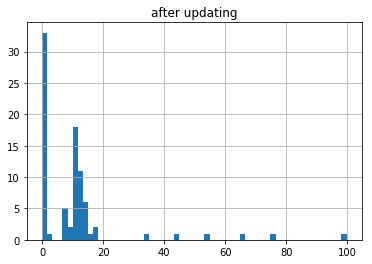

In [19]:
# Investigate patterns in the amount of missing data in each column.

proportion_value.hist(bins = 60)

<function matplotlib.pyplot.show(*args, **kw)>

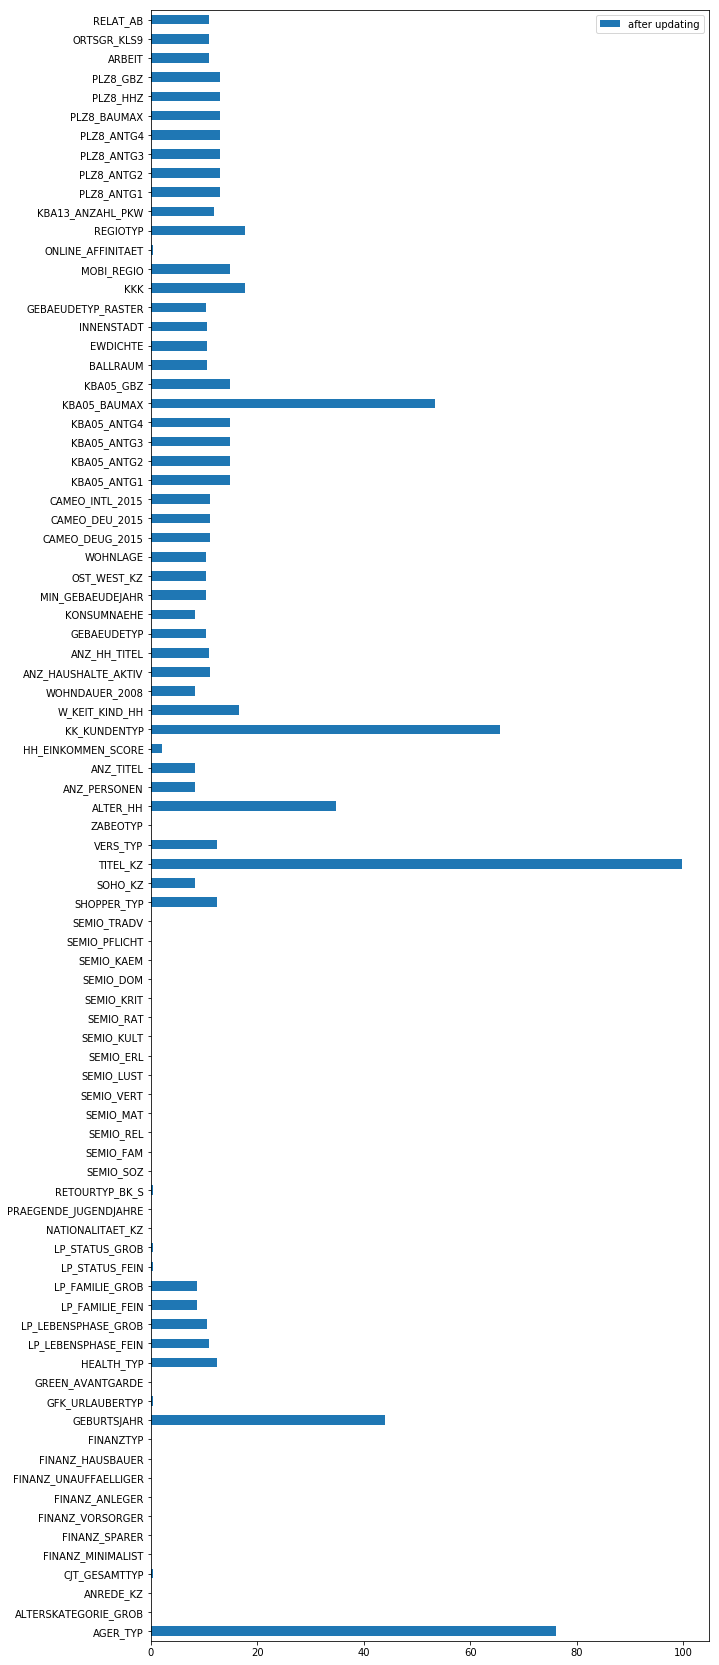

In [20]:
# let's view how much each column is missing 
proportion_value.plot.barh(figsize = (10,30))
plt.show

In [21]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# I will need to drop the columns that contains more than %20 missing values

drop_column = proportion_value[proportion_value['after updating'] > 20]
drop_column = drop_column.transpose()
new_azdias = azdias.drop(drop_column, axis = 1)
print(new_azdias.shape)



(891221, 79)


In [22]:
display(new_azdias.describe())

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,6.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


,AGER_TYP,GEBURTSJAHR,TITEL_KZ,ALTER_HH,KK_KUNDENTYP,KBA05_BAUMAX
after updating,76.01964,44.020282,99.757636,34.813699,65.596749,53.468668


<function matplotlib.pyplot.show(*args, **kw)>

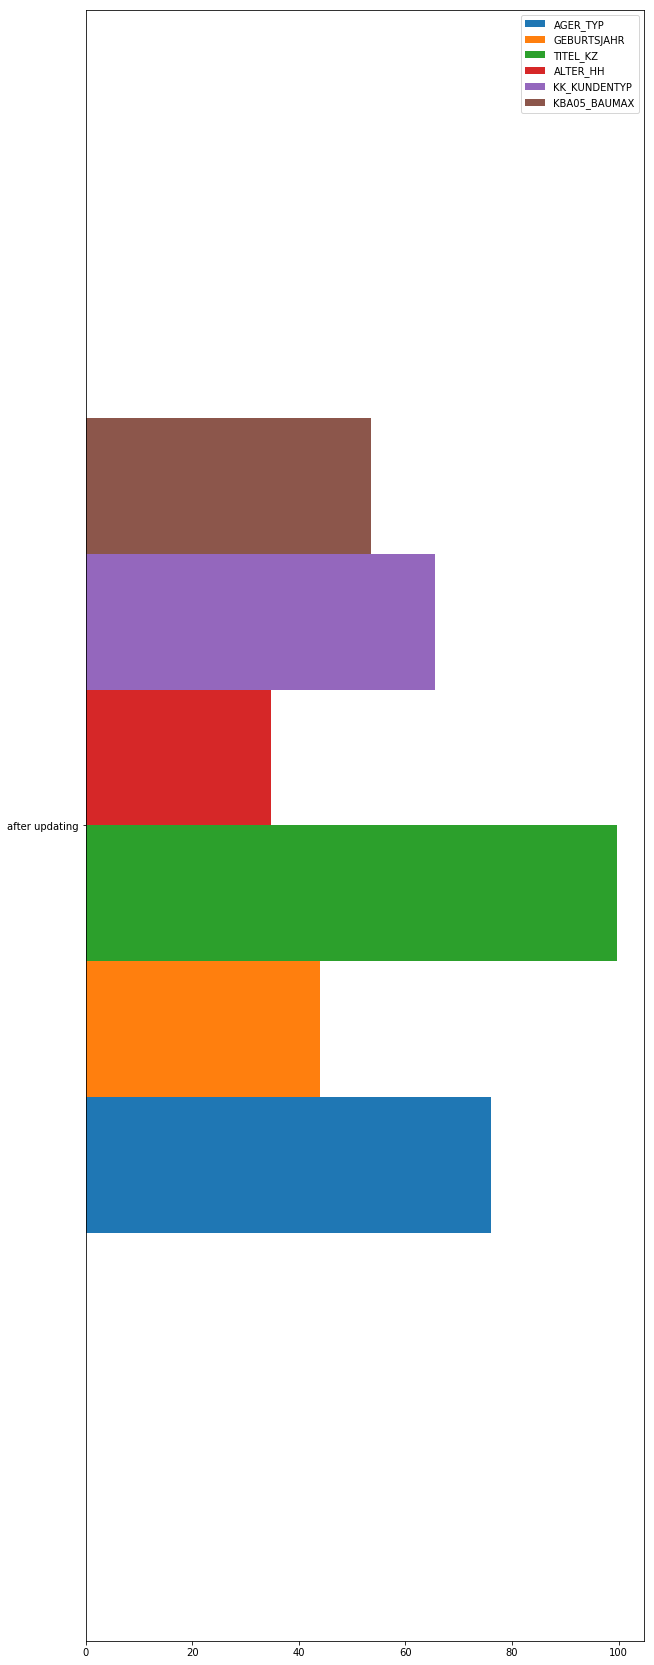

In [23]:
#show the rows that were removed from the dataset and their percentage 


display(drop_column)


drop_column.plot.barh(figsize = (10,30))
plt.show

In [24]:
# now lets drop the features in feat_info that were dropped form the azdias
#the code below will mark the features in attribute as true if it is exist in drop_column 
# so it can be recognized in the next line of code to be dropped

feat_info_temp = feat_info.isin(drop_column.columns.values.tolist())

feat_info_new = feat_info.drop(feat_info_temp[feat_info_temp.attribute == True].index)

display(feat_info_new)
print(feat_info_new.shape)

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]
10,FINANZTYP,person,categorical,[-1]


(79, 4)


In [25]:
# double check that these features were removed
print("old version of feat_info")
print(feat_info.shape)

print("new version of feat_info")
print(feat_info_new.shape)

old version of feat_info
(85, 4)
new version of feat_info
(79, 4)


#### Discussion 1.1.2: Assess Missing Data in Each Column

there are many columns with missing values, and also, there are many columns with no missing values. after minning the data and filled up the cells that have unknown data with NaN. I got the accuracy of missing values in each column. I found out that there are varies results. I have erased every column that have more than 20% of missing values. 

some of removed columns:
	AGER_TYP	GEBURTSJAHR	TITEL_KZ	ALTER_HH	KK_KUNDENTYP	W_KEIT_KIND_HH	KBA05_BAUMAX	KKK	     REGIOTYP
	76.01964	44.020282	99.757636	34.813699	65.596749	    16.605084	   53.468668	 17.735668	17.735668



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [26]:
# How much data is missing in each row of the dataset?
missing_in_rows = pd.DataFrame(new_azdias.isnull().sum(axis = 1), columns = ['missing_each_row'])

print(missing_in_rows)

        missing_each_row
0                     41
1                      0
2                      0
3                      7
4                      0
5                      0
6                      0
7                      0
8                      0
9                      0
10                     0
11                    45
12                     6
13                     8
14                    45
15                     8
16                     6
17                    45
18                     3
19                     0
20                    10
21                     0
22                     0
23                     8
24                    45
25                     5
26                    19
27                     0
28                     0
29                     2
...                  ...
891191                 0
891192                 0
891193                 0
891194                 0
891195                 0
891196                 0
891197                 0
891198                 0


In [27]:
# let's add this column to the original database, so we can use this column later if needed
new_azdias_2 = new_azdias.join(missing_in_rows)

display(new_azdias_2)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_each_row
0,2,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41
1,1,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3,1,5.0,4,3,4,1,3,2,5,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0
5,1,2,2.0,3,1,5,2,2,5,2,...,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0
6,2,2,5.0,1,5,1,5,4,3,4,...,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,0
7,1,1,3.0,3,3,4,1,3,2,5,...,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0,0
8,3,1,3.0,4,4,2,4,2,2,6,...,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0,0
9,3,2,4.0,2,4,2,3,5,4,1,...,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0,0


In [28]:
missing_in_rows.describe()

,missing_each_row
count,891221.000000
mean,5.403760
std,12.719533
min,0.000000
25%,0.000000
50%,0.000000
75%,3.000000
max,47.000000


In [29]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_1 = new_azdias_2[new_azdias_2['missing_each_row'] <=20]
azdias_2 = new_azdias_2[new_azdias_2['missing_each_row'] > 20]




In [30]:
#let's check if they were split or not  by checking the value of the shape of each and using hist
print("first split")
print(azdias_1.shape)
print("second_split")
print(azdias_2.shape)


first split
(797569, 80)
second_split
(93652, 80)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d587a9a20>]], dtype=object)

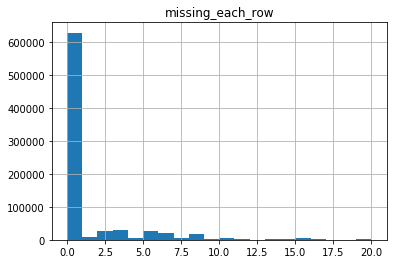

In [31]:
azdias_1.hist(column = 'missing_each_row', bins = 20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d58736cc0>]], dtype=object)

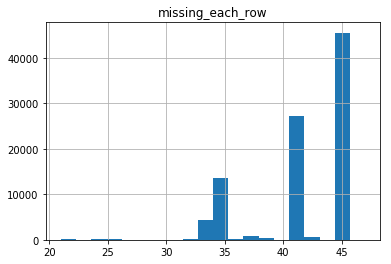

In [32]:
azdias_2.hist(column = 'missing_each_row', bins = 20)

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


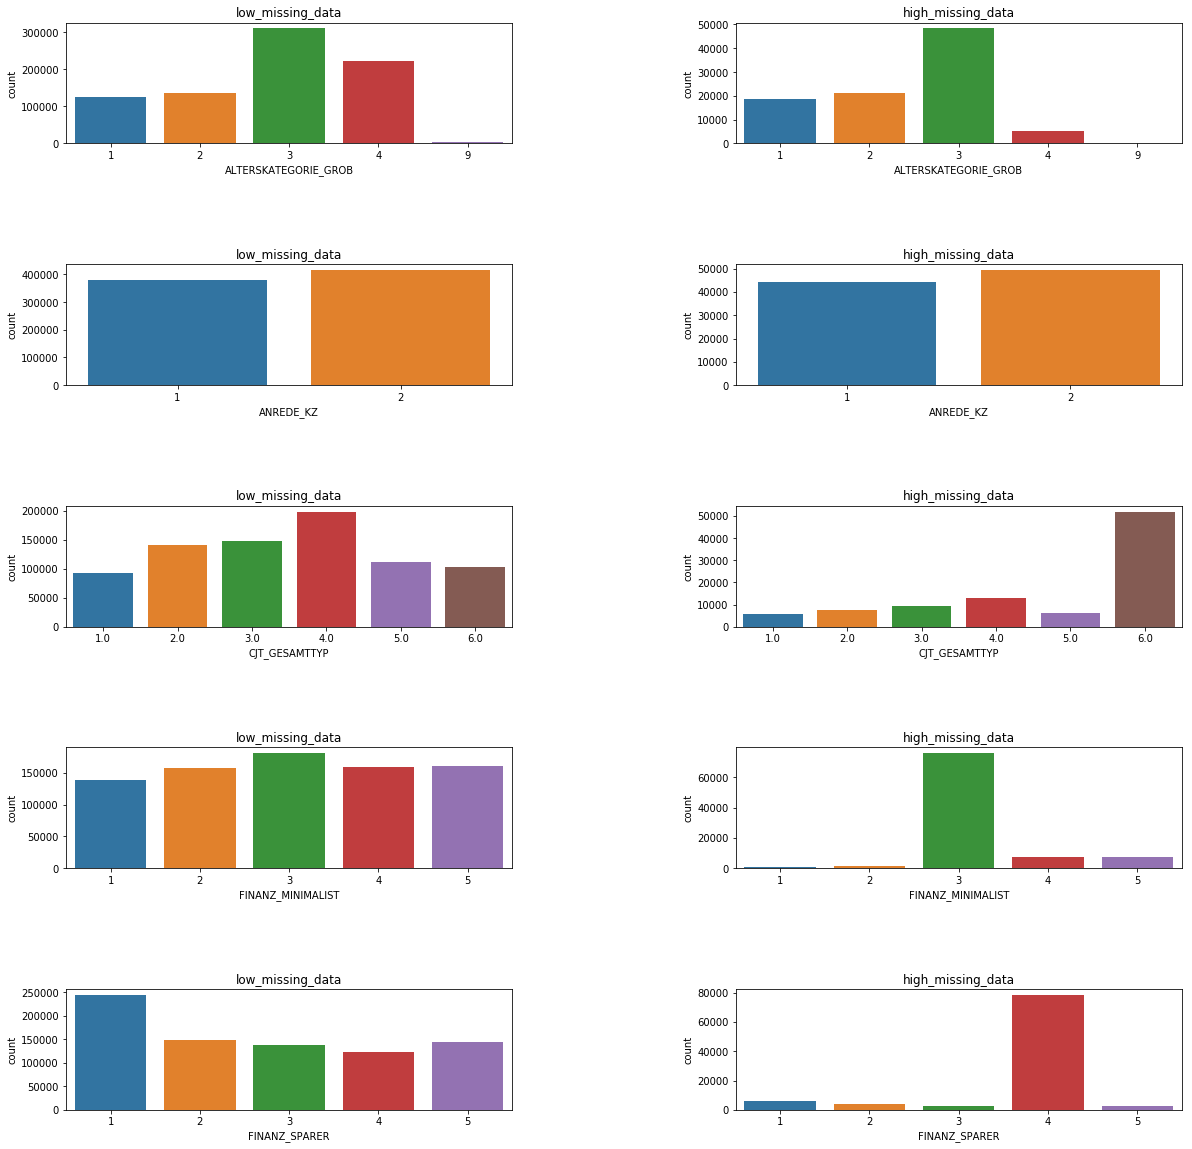

In [33]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
import seaborn as sns
column_names = new_azdias.columns

def countplots(low_missing_data,high_missing_data, column, num):
    fig, ax = plt.subplots(num,2, figsize = (20,20))
    fig.subplots_adjust(hspace = 1, wspace = 1)
    ax = ax.ravel()
    for i in range(num):
        
        sns.countplot(low_missing_data[column[i]], ax = ax[i*2])
        ax[i*2].set_title("low_missing_data")
        sns.countplot(high_missing_data[column[i]], ax = ax[i*2+1])
        ax[i*2+1].set_title("high_missing_data")
        plt.subplots_adjust(wspace = 0.5)
        fig.show()
    

countplots(azdias_1,azdias_2, column_names, 5)
#missing_row = high_missing_data.isnull().sum(axis=1)
#missing_row.sort_values(inplace=True)
#print(missing_row)

In [34]:

column_names = azdias_1.columns
print(column_names)

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

In [35]:
print(feat_info_new)

                attribute information_level         type missing_or_unknown
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
12        GFK_URLAUBERTYP            person  categorical                 []
13       GREEN_AVANTGARDE            person  categorical                 []
14          

In [36]:
# check the type of data in each column
azdias_1.dtypes

ALTERSKATEGORIE_GROB       int64
ANREDE_KZ                  int64
CJT_GESAMTTYP            float64
FINANZ_MINIMALIST          int64
FINANZ_SPARER              int64
FINANZ_VORSORGER           int64
FINANZ_ANLEGER             int64
FINANZ_UNAUFFAELLIGER      int64
FINANZ_HAUSBAUER           int64
FINANZTYP                  int64
GFK_URLAUBERTYP          float64
GREEN_AVANTGARDE           int64
HEALTH_TYP               float64
LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
LP_FAMILIE_FEIN          float64
LP_FAMILIE_GROB          float64
LP_STATUS_FEIN           float64
LP_STATUS_GROB           float64
NATIONALITAET_KZ           int64
PRAEGENDE_JUGENDJAHRE      int64
RETOURTYP_BK_S           float64
SEMIO_SOZ                  int64
SEMIO_FAM                  int64
SEMIO_REL                  int64
SEMIO_MAT                  int64
SEMIO_VERT                 int64
SEMIO_LUST                 int64
SEMIO_ERL                  int64
SEMIO_KULT                 int64
          

In [37]:
display(azdias_1)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_each_row
1,1,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3,1,5.0,4,3,4,1,3,2,5,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0
5,1,2,2.0,3,1,5,2,2,5,2,...,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0
6,2,2,5.0,1,5,1,5,4,3,4,...,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,0
7,1,1,3.0,3,3,4,1,3,2,5,...,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0,0
8,3,1,3.0,4,4,2,4,2,2,6,...,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0,0
9,3,2,4.0,2,4,2,3,5,4,1,...,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0,0
10,3,2,1.0,2,2,5,3,1,5,6,...,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0,0


In [38]:
#azdias_1.mode()

In [39]:
class DFImputer(TransformerMixin):
    def _init_(self):
        """ hello World"""
    #print("I am here 1")
    def fit(self, X, y=None):
        
        #print("I am here 2")
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index = X.columns)
        #print("I am here 3")
        return self
    #print("I am here 4")
    def transform(self, X, y=None):
        return X.fillna(self.fill)


    

In [40]:
azdias_1_copy = pd.DataFrame(DFImputer().fit_transform(azdias_1))

azdias_1_copy.columns = azdias_1.columns # restore column names
azdias_1_copy.index = azdias_1.index # restore indexs 

azdias_1 = azdias_1_copy

display(azdias_1.head(n=5))

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_each_row
1,1,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3,1,5.0,4,3,4,1,3,2,5,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0
5,1,2,2.0,3,1,5,2,2,5,2,...,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

I split the data based on the average of the missing value.

the shape of low_missing_data:
(797569, 80)
the shape of high_missing_data:
(93652, 80)

in the chart, we will see the low_missing_data has more missing value than the high_mising_value, but the truth is the opposite because the low_missing_data has more rows in it. 

however, the low_missing_data still have many missing value in it. I need to fix this issue.

now, I am left with one option which is to replace the missing numeric data with the average, and the the non-numeric value with the most repeated value. in order to have data with free of missing value. 

but first, I need to see the dataType of each column to decide how to fix the data


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [41]:
# How many features are there of each data type?

num_features = feat_info_new.type.value_counts()
display(num_features)


ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [42]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?


categorical_feat = feat_info_new[feat_info_new['type'] == 'categorical']

display(categorical_feat)


,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [43]:
# Re-encode categorical variable(s) to be kept in the analysis.
# extract categorical columns and check how many categoriy in each column
# then put the column that has more than two categories in a list for later use
list_categorical = []

for col in (categorical_feat['attribute']):
    print(col)
    unique_val = azdias_1[col].unique()
    display(unique_val)
    
    if unique_val.size > 2:
        list_categorical.append(col)





ANREDE_KZ


array([2, 1])

CJT_GESAMTTYP


array([ 5.,  3.,  2.,  4.,  1.,  6.])

FINANZTYP


array([1, 6, 5, 2, 4, 3])

GFK_URLAUBERTYP


array([ 10.,   1.,   5.,  12.,   9.,   3.,   8.,  11.,   4.,   2.,   7.,
         6.])

GREEN_AVANTGARDE


array([0, 1])

LP_FAMILIE_FEIN


array([  5.,   1.,  10.,   2.,   7.,  11.,   8.,   4.,   6.,   9.,   3.])

LP_FAMILIE_GROB


array([ 3.,  1.,  5.,  2.,  4.])

LP_STATUS_FEIN


array([  2.,   3.,   9.,   4.,   1.,  10.,   5.,   8.,   6.,   7.])

LP_STATUS_GROB


array([ 1.,  2.,  4.,  5.,  3.])

NATIONALITAET_KZ


array([1, 3, 2, 0])

SHOPPER_TYP


array([ 3.,  2.,  1.,  0.])

SOHO_KZ


array([ 1.,  0.])

VERS_TYP


array([ 2.,  1.])

ZABEOTYP


array([5, 3, 4, 1, 6, 2])

GEBAEUDETYP


array([ 8.,  1.,  3.,  2.,  6.,  4.,  5.])

OST_WEST_KZ


array(['W', 'O'], dtype=object)

CAMEO_DEUG_2015


array(['8', '4', '2', '6', '1', '9', '5', '7', '3'], dtype=object)

CAMEO_DEU_2015


array(['8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '5C',
       '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C', '5A',
       '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D', '8D',
       '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F', '1C'], dtype=object)

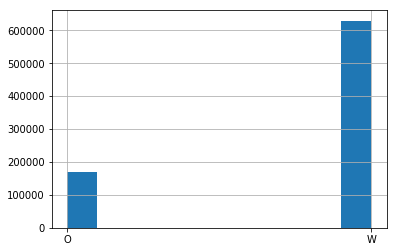

In [44]:
#let's check OST_WEST_KZ column

azdias_1 ['OST_WEST_KZ'].hist()

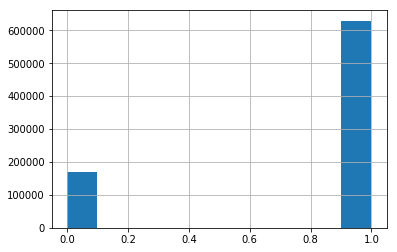

In [45]:
#need to adjust the values in the OST_WEST_KZ column by replacing O with zero and W with one

azdias_1.OST_WEST_KZ = azdias_1.OST_WEST_KZ.replace({'O' : 0.0, 'W' : 1.0})

# check the result to see if values have been replaced or not
azdias_1 ['OST_WEST_KZ'].hist()

In [46]:
#display the list_categorical

print(list_categorical)

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [47]:
# as we can see above that some columns have more than two categories
# it is really hard to encode categories that have more than two categories
# now I will get rid of these columns with more than two categories. only need binary categorical



In [48]:
#then remove these columns

for col in list_categorical:
    azdias_1.drop(col, axis=1, inplace=True)

#double check to see if the number of columns have been reduced or not
print(azdias_1.shape)
    

(797569, 67)


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)


for the binary and one value categoricals, i kept them as is without any changes. I replaced the values in OST_WEST_KZ column from 'O' to '0' and 'W' to '1'.  

I dropped all the columns that have more than two features becausec I did not want my algorithms to get confused. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [49]:
# now it is time to check the mixed data type in the dataset to see what we can do with after exploring them
mixed_feat = feat_info_new[feat_info_new['type'] == 'mixed']

display(mixed_feat)



,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [50]:
# checking the uniqueness of mixed_features 

for col in (mixed_feat['attribute']):
    print(col)
    unique_val = azdias_1[col].unique()
    display(unique_val)

LP_LEBENSPHASE_FEIN


array([ 21.,   3.,  13.,  32.,   8.,   2.,   5.,  10.,   4.,   6.,  23.,
        12.,  20.,   1.,  11.,  25.,  18.,  31.,  38.,  35.,  30.,   7.,
        22.,  14.,  29.,  24.,  28.,  37.,  26.,  39.,  27.,  36.,   9.,
        34.,  33.,  15.,  40.,  16.,  19.,  17.])

LP_LEBENSPHASE_GROB


array([  6.,   1.,   3.,  10.,   2.,   5.,   7.,  12.,  11.,   9.,   4.,
         8.])

PRAEGENDE_JUGENDJAHRE


array([14, 15,  8,  3, 10, 11,  5,  9,  6,  4,  0,  2,  1, 12, 13,  7])

WOHNLAGE


array([ 4.,  2.,  7.,  3.,  5.,  1.,  8.,  0.])

CAMEO_INTL_2015


array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

PLZ8_BAUMAX


array([ 1.,  2.,  4.,  5.,  3.])

In [51]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
#we need to create two varibales of PRAEGENDE_JUGENDJAHRE

azdias_1['PRAEGENDE_JUGENDJAHRE_decade'] = azdias['PRAEGENDE_JUGENDJAHRE']
azdias_1['PRAEGENDE_JUGENDJAHRE_movement'] = azdias['PRAEGENDE_JUGENDJAHRE']


In [52]:
# now lets decode these two variables 

decade_list = {1:20.0,
               2:20.0,
               3:30.0,
               4:30.0,
               5:40.0,
               6:50.0,
               7:50.0,
               8:60.0,
               9:60.0,
               10:70.0,
               11:80.0,
               12:80.0,
               13:90.0,
               14:90.0,
               15:90.0,
               }

azdias_1.PRAEGENDE_JUGENDJAHRE_decade = azdias_1.PRAEGENDE_JUGENDJAHRE_decade.replace(decade_list)

movement_list = {1:0.0,
               2:1.0,
               3:0.0,
               4:1.0,
               5:0.0,
               6:1.0,
               7:0.0,
               8:1.0,
               9:0.0,
               10:1.0,
               11:0.0,
               12:1.0,
               13:0.0,
               14:1.0,
               15:0.0,
               }

azdias_1.PRAEGENDE_JUGENDJAHRE_movement = azdias_1.PRAEGENDE_JUGENDJAHRE_movement.replace(movement_list)



In [53]:
#display the data to see the changes that have been made on the data
display(azdias_1.head(n=2))

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_each_row,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement
1,1,2,1,5,2,5,4,5,0,3.0,...,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,90.0,1.0
2,3,2,1,4,1,2,3,5,1,3.0,...,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,90.0,0.0


In [54]:
# now drop the PRAEGENDE_JUGENDJAHRE column from the data
azdias_1.drop(['PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace = True)

In [55]:
#display the data again to see the changes that have been made on the data
display(azdias_1.head(n=5))

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_each_row,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement
1,1,2,1,5,2,5,4,5,0,3.0,...,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,90.0,1.0
2,3,2,1,4,1,2,3,5,1,3.0,...,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,90.0,0.0
3,4,2,4,2,5,2,1,2,0,2.0,...,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7,60.0,1.0
4,3,1,4,3,4,1,3,2,0,3.0,...,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,60.0,1.0
5,1,2,3,1,5,2,2,5,0,3.0,...,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,30.0,0.0


In [56]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

unique_val = azdias_1['CAMEO_INTL_2015'].unique()
unique_val.sort()
print(unique_val)

['12' '13' '14' '15' '22' '23' '24' '25' '31' '32' '33' '34' '35' '41' '43'
 '44' '45' '51' '52' '54' '55']


In [57]:
# It sounds we need to divide the CAMEO_INTL_2015 column into two columns wealth of life and stage of life

azdias_1['CAMEO_INTL_2015_LS'] = azdias_1['CAMEO_INTL_2015']
azdias_1['CAMEO_INTL_2015_W'] = azdias_1['CAMEO_INTL_2015']

In [58]:
dict_LS =   {'12': 2.0,
             '13': 3.0,
             '14': 4.0,
             '15': 5.0,
             '22': 2.0,
             '23': 3.0,
             '24': 4.0,
             '25': 5.0,
             '31': 1.0,
             '32': 2.0,
             '33': 3.0,
             '34': 4.0,
             '35': 5.0,
             '41': 1.0,
             '43': 3.0,
             '44': 4.0,
             '45': 5.0,
             '51': 1.0,
             '52': 2.0,
             '54': 4.0,
             '55': 5.0,}

azdias_1.CAMEO_INTL_2015_LS = azdias_1.CAMEO_INTL_2015_LS.replace(dict_LS)


dict_W = { '12': 1.0,
         '13': 1.0,
         '14': 1.0,
         '15': 1.0,
         '22': 2.0,
         '23': 2.0,
         '24': 2.0,
         '25': 2.0,
         '31': 3.0,
         '32': 3.0,
         '33': 3.0,
         '34': 3.0,
         '35': 3.0,
         '41': 4.0,
         '43': 4.0,
         '44': 4.0,
         '45': 4.0,
         '51': 5.0,
         '52': 5.0,
         '54': 5.0,
         '55': 5.0,
         }


azdias_1.CAMEO_INTL_2015_W = azdias_1.CAMEO_INTL_2015_W.replace(dict_W)

In [59]:
#let's check the changes that happen on these two columns

display (azdias_1['CAMEO_INTL_2015_LS'].head(n=5))
display (azdias_1['CAMEO_INTL_2015_W'].head(n=5))

1    1.0
2    4.0
3    2.0
4    3.0
5    4.0
Name: CAMEO_INTL_2015_LS, dtype: float64

1    5.0
2    2.0
3    1.0
4    4.0
5    5.0
Name: CAMEO_INTL_2015_W, dtype: float64

In [60]:
display(azdias_1.head(n=5))

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_each_row,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_LS,CAMEO_INTL_2015_W
1,1,2,1,5,2,5,4,5,0,3.0,...,5.0,4.0,3.0,5.0,4.0,0,90.0,1.0,1.0,5.0
2,3,2,1,4,1,2,3,5,1,3.0,...,4.0,4.0,3.0,5.0,2.0,0,90.0,0.0,4.0,2.0
3,4,2,4,2,5,2,1,2,0,2.0,...,3.0,4.0,2.0,3.0,3.0,7,60.0,1.0,2.0,1.0
4,3,1,4,3,4,1,3,2,0,3.0,...,3.0,3.0,4.0,6.0,5.0,0,60.0,1.0,3.0,4.0
5,1,2,3,1,5,2,2,5,0,3.0,...,5.0,5.0,2.0,3.0,3.0,0,30.0,0.0,4.0,5.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

 I reencoded CAMEO_INTL_2015 column by dividing it into two columns 
 
 first column about  life  stage consist of:
 
  *Pre-Family Couples & Singles: 1
  *Young Couples With Childeren: 2
  *Families With School Age Children: 3
  *Older Families & Mature Couples: 4
  *Elders In Retirement: 5
 
 second column about wealth stage consist of:
 
  *Wealthy Households: 1
  *Prosperous Households: 2
  *Comfortable Households 3
  *Less Affluent Households: 4
  *Poorer Households: 5

also, I decided to drop PLZ8_BAUMAX column because it has been covered mostly by several columns: PLZ8_ANTG1, PLZ8_ANTG2, PLZ8_ANTG3, PLZ8_ANTG4. 


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [61]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [62]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# dropping these two columns that I do not need to pass to the algorithm

azdias_1.drop(['CAMEO_INTL_2015','PLZ8_BAUMAX'], axis = 1, inplace = True)


display(azdias_1.head(n=5))



,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_each_row,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_LS,CAMEO_INTL_2015_W
1,1,2,1,5,2,5,4,5,0,3.0,...,5.0,4.0,3.0,5.0,4.0,0,90.0,1.0,1.0,5.0
2,3,2,1,4,1,2,3,5,1,3.0,...,4.0,4.0,3.0,5.0,2.0,0,90.0,0.0,4.0,2.0
3,4,2,4,2,5,2,1,2,0,2.0,...,3.0,4.0,2.0,3.0,3.0,7,60.0,1.0,2.0,1.0
4,3,1,4,3,4,1,3,2,0,3.0,...,3.0,3.0,4.0,6.0,5.0,0,60.0,1.0,3.0,4.0
5,1,2,3,1,5,2,2,5,0,3.0,...,5.0,5.0,2.0,3.0,3.0,0,30.0,0.0,4.0,5.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [63]:
def clean_data(azdias):
    
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    
    print("1")
    display(azdias['CAMEO_INTL_2015'])

    column_names = azdias.columns

    # preocess missing_or_unknown column in the feat_info

    char_to_eliminate = ['\[', '\]']

    missing_value = feat_info ['missing_or_unknown'].replace(to_replace = char_to_eliminate, value = '', regex = True)




    # create a list of these unknown value to process it later by converting int numbers to float.

    missing_val = []
    # for the purpose to know exacly what values are considered unknown, also to build a big picturte of what I am doing
    unique_list = []

    for val in range(len(missing_value)):

        missing_val.append(missing_value[val].split(','))
        nn = missing_value[val].split(',')
        if nn not in unique_list: 
                unique_list.append(nn)


    # conversting int values to float values because the population data has float numbers not int
    #so I need to fix this issue inorder to replace these values with NaN

    for i in range(len(missing_val)):
        for j in range(len(missing_val[i])):
            if (missing_val [i][j] == 'X' or missing_val [i][j] == 'XX' or missing_val [i][j] == '' ):
                pass
            else:
                missing_val [i][j] = float(missing_val [i][j])



    # filling up the missing values with NaN

    for i in range(len(missing_val)):

        azdias[feat_info.iloc[i]['attribute']].replace(to_replace = missing_val[i], value = np.NaN, regex = True, inplace = True)




    print("2")
    display(azdias['CAMEO_INTL_2015'])

    # Perform an assessment of how much missing data there is in each column of the
    # dataset.

    new_azdias = azdias.drop(drop_column, axis = 1)

    missing_rows = pd.DataFrame(new_azdias.isnull().sum(axis = 1), columns = ['missing_each_rows'])
    
    new_azdias_1 = new_azdias.join(missing_rows)
    
    
    
    new_azdias_2 = new_azdias_1[new_azdias_1['missing_each_rows'] <= 20]

    
    new_azdias_2_more_10 = new_azdias_1[new_azdias_1['missing_each_rows'] > 20]
    
    new_azdias_2_more_10.columns = new_azdias_1.columns
    
    new_azdias_2_more_10 = new_azdias_2_more_10.drop('missing_each_rows', axis = 1)

    # Remove the outlier columns from the dataset. (You'll perform other data
    # engineering tasks such as re-encoding and imputation later.)

    # I will need to drop the columns that contains more than %20 missing values

    drop_rows = new_azdias_1[new_azdias_1['missing_each_rows'] > 20].shape[0]
    
    
    number_of_rows = new_azdias_1.shape[0]

    
    index = new_azdias_2.index
    
    new_azdias_2 = new_azdias_2.drop ('missing_each_rows', axis = 1)
    
    
    
    new_azdias_2_impute = pd.DataFrame(DFImputer().fit_transform(new_azdias_2))
    
    new_azdias_2_impute.columns = new_azdias_2.columns
    new_azdias_2_impute.index = new_azdias_2.index
    
    new_azdias_2 = new_azdias_2_impute


    print("3")
    display(new_azdias_2['CAMEO_INTL_2015'])








    #need to adjust the values in the OST_WEST_KZ column by replacing O with zero and W with one

    new_azdias_2.OST_WEST_KZ = new_azdias_2.OST_WEST_KZ.replace({'O' : 0.0,'W' : 1.0})



    azdias_1=new_azdias_2

    #then remove these columns

    for col in list_categorical:
        azdias_1.drop(col, axis=1, inplace=True)

    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    #we need to create two varibales of PRAEGENDE_JUGENDJAHRE

    azdias_1['PRAEGENDE_JUGENDJAHRE_decade'] = azdias_1['PRAEGENDE_JUGENDJAHRE']
    azdias_1['PRAEGENDE_JUGENDJAHRE_movement'] = azdias_1['PRAEGENDE_JUGENDJAHRE']







    # now lets decode these two variables 

    

    azdias_1.PRAEGENDE_JUGENDJAHRE_decade = azdias_1.PRAEGENDE_JUGENDJAHRE_decade.replace(decade_list)

 

    azdias_1.PRAEGENDE_JUGENDJAHRE_movement = azdias_1.PRAEGENDE_JUGENDJAHRE_movement.replace(movement_list)



    # now drop the PRAEGENDE_JUGENDJAHRE column from the data
    azdias_1.drop(['PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace = True)


    # Investigate "CAMEO_INTL_2015" and engineer two new variables.

    unique_val = azdias_1['CAMEO_INTL_2015'].unique()




    # It sounds we need to divide the CAMEO_INTL_2015 column into two columns wealth of life and stage of life

    azdias_1['CAMEO_INTL_2015_LS'] = azdias_1['CAMEO_INTL_2015']
    azdias_1['CAMEO_INTL_2015_W'] = azdias_1['CAMEO_INTL_2015']



    azdias_1.CAMEO_INTL_2015_LS = azdias_1.CAMEO_INTL_2015_LS.replace(dict_LS)


   


    azdias_1.CAMEO_INTL_2015_W = azdias_1.CAMEO_INTL_2015_W.replace(dict_W)



    # dropping these two columns that I do not need to pass to the algorithm

    azdias_1.drop(['CAMEO_INTL_2015','PLZ8_BAUMAX'], axis = 1, inplace = True)





















    

    return azdias_1, number_of_rows, index,drop_rows,new_azdias_2_more_10
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [64]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.



In [65]:
# Apply feature scaling to the general population demographics data.
def scaling(azdias_1):
    
    scaler = StandardScaler()
    azdias_scaler = pd.DataFrame(scaler.fit_transform(azdias_1))
    azdias_scaler.columns = azdias_1.columns
    azdias_scaler.index = azdias_1.index

    display(azdias_scaler.head(n=10))
    
    return azdias_scaler
    
azdias_scaler=scaling(azdias_1)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_each_row,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_LS,CAMEO_INTL_2015_W
1,-1.681503,0.957985,-1.494511,1.538022,-1.040712,1.466190,0.959334,1.338918,-0.530510,1.096291,...,1.430323,0.573953,-0.166548,-0.127147,0.684775,-0.407560,1.115024,0.795960,-1.249173,1.175778
2,0.169284,0.957985,-1.494511,0.864667,-1.766964,-0.570915,0.244699,1.338918,1.884977,1.096291,...,0.390903,0.573953,-0.166548,-0.127147,-0.789116,-0.407560,1.115024,-1.256344,0.766861,-0.869624
3,1.094678,0.957985,0.683250,-0.482042,1.138045,-0.570915,-1.184571,-0.791920,-0.530510,-0.257226,...,-0.648517,0.573953,-1.170063,-0.997681,-0.052170,2.019799,-0.098257,0.795960,-0.577162,-1.551424
4,0.169284,-1.043857,0.683250,0.191312,0.411793,-1.249949,0.244699,-0.791920,-0.530510,1.096291,...,-0.648517,-0.337302,0.836967,0.308120,1.421721,-0.407560,-0.098257,0.795960,0.094849,0.493978
5,-1.681503,0.957985,-0.042670,-1.155397,1.138045,-0.570915,-0.469936,1.338918,-0.530510,1.096291,...,1.430323,1.485208,-1.170063,-0.997681,-0.052170,-0.407560,-1.311539,-1.256344,0.766861,1.175778
6,-0.756109,0.957985,-1.494511,1.538022,-1.766964,1.466190,0.959334,-0.081641,-0.530510,-0.257226,...,1.430323,1.485208,0.836967,0.308120,-0.052170,-0.407560,0.306170,0.795960,-0.577162,-0.869624
7,-1.681503,-1.043857,-0.042670,0.191312,0.411793,-1.249949,0.244699,-0.791920,-0.530510,-1.610742,...,0.390903,0.573953,-1.170063,-0.127147,-0.789116,-0.407560,-0.098257,0.795960,0.766861,-1.551424
8,0.169284,-1.043857,0.683250,0.864667,-1.040712,0.787155,-0.469936,-0.791920,1.884977,1.096291,...,-0.648517,-0.337302,-1.170063,-0.562414,-0.052170,-0.407560,0.710597,-1.256344,0.094849,-1.551424
9,0.169284,0.957985,-0.768591,0.864667,-1.040712,0.108120,1.673969,0.628638,1.884977,-0.257226,...,-0.648517,-0.337302,-1.170063,-0.997681,-1.526062,-0.407560,1.115024,-1.256344,1.438872,-1.551424
10,0.169284,0.957985,-0.768591,-0.482042,1.138045,0.108120,-1.184571,1.338918,-0.530510,-0.257226,...,-0.648517,-0.337302,0.836967,0.308120,1.421721,-0.407560,-1.311539,-1.256344,-1.249173,1.175778


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)


I dropped the columns that contained more than 20% of missing values because if I keep them I will not get a proper accuraccy with a lot of NaN values in those columns with more than 20% NaN values. 


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [66]:
# Apply PCA to the data.
pca = PCA(n_components = 34)

azdias_scaler_pca = pca.fit_transform(azdias_scaler)

display(azdias_scaler_pca)



array([[ 3.45928812, -2.93193217, -2.94305261, ..., -0.05276522,
         0.49389149, -0.73581815],
       [-0.37949633,  0.6862076 , -3.01908486, ...,  0.81298232,
        -0.81449497,  0.02629315],
       [-3.73084467,  1.33824215, -0.80890112, ...,  0.58915825,
         0.92027686,  0.06344869],
       ..., 
       [-1.22687754, -3.32598214, -2.97110652, ...,  0.85635335,
         0.53279715, -0.58757112],
       [ 5.10030421, -3.94874308,  2.23019568, ...,  0.20703949,
         0.02453016,  0.35077181],
       [-0.42935572,  1.21111693,  3.21460502, ...,  0.09174728,
         1.12658247, -0.42551245]])

In [67]:
def pca_results(dataset, pca):
    
    
    dimentions = dimensions = ['Dimension {}'.format(i) for i in range(1, len(pca.components_)+1)]
    
    components = pd.DataFrame(np.round(pca.components_, 4), columns = dataset.keys())
    components.index = dimensions
    
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained_Variance'])
    variance_ratios.index = dimensions
    
    fig, ax = plt.subplots(figsize = (14,8))
    
    
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature_Weight")
    ax.set_xticklabels(dimensions, rotation=0)
    
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained_Variance\n       %.4f"%(ev))
        
    return pd.concat([variance_ratios, components], axis = 1)


def scree_plot(pca):
    
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
    plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center",fontsize = 12)
        ax.xaxis.set_tick_params(width = 0)
        ax.yaxis.set_tick_params(width = 2, length = 12)
        
        ax.set_xlabel("Principal Component")
        ax.set_ylabel("variance Explained (%)")
        plt.title('Explained Variance per principal Componoent')
        
        
    

,Explained_Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_each_row,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_LS,CAMEO_INTL_2015_W
Dimension 1,0.1628,-0.0913,0.0100,-0.2092,0.1251,-0.0943,0.0483,0.0566,0.1661,-0.0996,...,0.0439,-0.1661,0.1461,0.2037,0.1382,-0.0136,0.0540,0.0617,-0.1197,0.2042
Dimension 2,0.1268,0.2552,0.0916,0.0821,-0.2449,0.2411,-0.2079,-0.2277,0.1057,-0.0018,...,0.0097,-0.0513,0.0525,0.0724,0.0518,-0.0224,-0.2427,-0.1257,0.0157,0.0521
Dimension 3,0.0889,0.0785,-0.3689,0.1584,-0.1096,0.1050,-0.1903,-0.1015,-0.0411,0.0435,...,0.0026,-0.0343,0.0315,0.0412,0.0287,-0.0202,-0.0883,-0.0644,-0.0061,0.0248
Dimension 4,0.0503,-0.0329,0.0231,0.0816,-0.0136,-0.0067,-0.1114,0.0486,-0.1162,0.3082,...,0.0922,-0.0112,0.0915,0.2586,0.1188,-0.0294,0.0721,-0.0799,0.0513,-0.0977
Dimension 5,0.0396,0.0374,-0.0039,0.0225,0.0004,-0.0235,0.1006,-0.0976,-0.0072,-0.1362,...,-0.3310,-0.3031,0.1280,-0.0302,0.0639,-0.0397,0.0260,0.0652,-0.0566,0.1099
Dimension 6,0.0322,0.0444,-0.0072,-0.0751,0.0227,0.0421,0.0499,-0.0066,0.0573,-0.1183,...,0.4082,0.2607,-0.1980,-0.1143,-0.1635,0.0065,-0.0245,0.0269,-0.0789,0.0804
Dimension 7,0.0300,-0.0091,0.0261,0.0051,-0.0061,-0.0467,-0.0148,0.0050,-0.0110,0.0646,...,-0.1173,-0.1619,-0.1377,-0.0429,-0.1721,0.1528,-0.0063,-0.0579,0.0699,-0.1028
Dimension 8,0.0281,-0.0819,0.0146,-0.0791,-0.0009,0.0314,0.0037,-0.1058,0.2016,0.0310,...,-0.0778,0.0296,-0.0118,-0.0138,-0.0160,-0.5834,0.0210,0.0073,0.0827,-0.0116
Dimension 9,0.0253,-0.0248,-0.0612,0.0702,0.0312,-0.0018,0.0168,0.0415,-0.1877,-0.0104,...,0.0947,0.0918,0.0149,0.1551,0.0275,-0.0138,0.0730,0.1108,-0.0144,-0.0555
Dimension 10,0.0227,-0.0988,0.0976,0.0391,-0.1326,0.1623,-0.0812,-0.0852,0.0955,-0.0251,...,0.0326,0.0622,0.0649,0.0692,0.0506,0.0626,-0.2527,-0.2001,0.0451,-0.0070


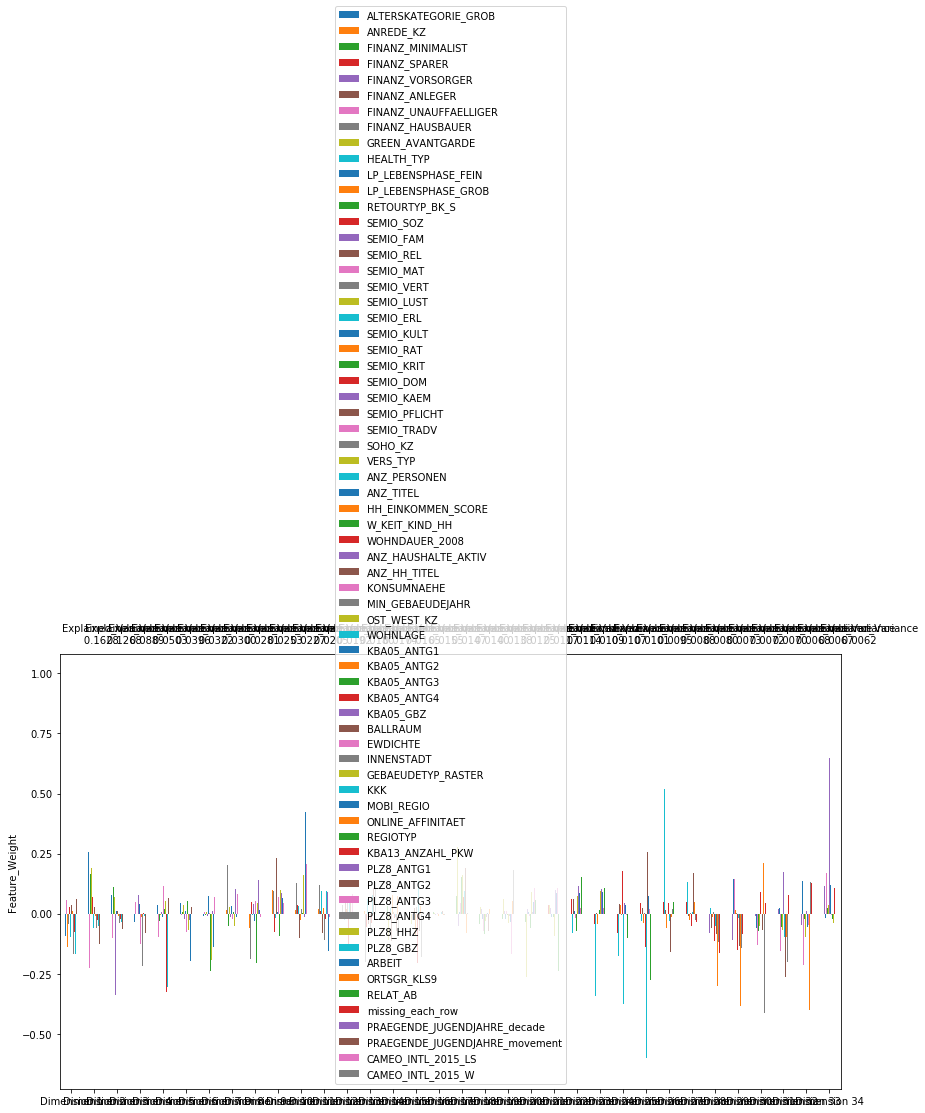

In [68]:
# Investigate the variance accounted for by each principal component.

pca_results(azdias_scaler, pca)

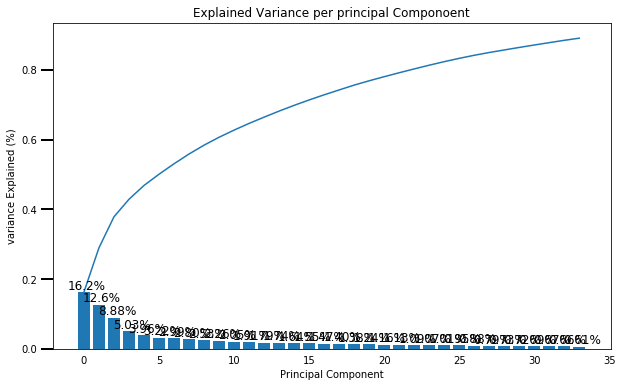

In [69]:
scree_plot(pca)

,Explained_Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_each_row,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_LS,CAMEO_INTL_2015_W
Dimension 1,0.1628,-0.0913,0.0100,-0.2092,0.1251,-0.0943,0.0483,0.0566,0.1661,-0.0996,...,0.0439,-0.1661,0.1461,0.2037,0.1382,-0.0136,0.0540,0.0617,-0.1197,0.2042
Dimension 2,0.1268,0.2552,0.0916,0.0821,-0.2449,0.2411,-0.2079,-0.2277,0.1057,-0.0018,...,0.0097,-0.0513,0.0525,0.0724,0.0518,-0.0224,-0.2427,-0.1257,0.0157,0.0521
Dimension 3,0.0889,0.0785,-0.3689,0.1584,-0.1096,0.1050,-0.1903,-0.1015,-0.0411,0.0435,...,0.0026,-0.0343,0.0315,0.0412,0.0287,-0.0202,-0.0883,-0.0644,-0.0061,0.0248
Dimension 4,0.0503,-0.0329,0.0231,0.0816,-0.0136,-0.0067,-0.1114,0.0486,-0.1162,0.3081,...,0.0922,-0.0112,0.0915,0.2586,0.1188,-0.0294,0.0721,-0.0799,0.0513,-0.0977
Dimension 5,0.0396,0.0373,-0.0039,0.0225,0.0003,-0.0234,0.1005,-0.0975,-0.0071,-0.1362,...,-0.3310,-0.3033,0.1279,-0.0302,0.0638,-0.0398,0.0261,0.0651,-0.0561,0.1099
Dimension 6,0.0322,0.0437,-0.0071,-0.0748,0.0225,0.0423,0.0500,-0.0068,0.0572,-0.1173,...,0.4084,0.2602,-0.1985,-0.1146,-0.1640,0.0064,-0.0240,0.0271,-0.0773,0.0804
Dimension 7,0.0300,-0.0094,0.0261,0.0050,-0.0061,-0.0467,-0.0147,0.0052,-0.0109,0.0651,...,-0.1170,-0.1620,-0.1378,-0.0430,-0.1723,0.1529,-0.0062,-0.0577,0.0705,-0.1029
Dimension 8,0.0281,-0.0827,0.0147,-0.0788,-0.0011,0.0315,0.0037,-0.1059,0.2014,0.0320,...,-0.0777,0.0292,-0.0124,-0.0141,-0.0172,-0.5837,0.0216,0.0073,0.0847,-0.0113
Dimension 9,0.0253,-0.0233,-0.0613,0.0703,0.0322,-0.0035,0.0172,0.0420,-0.1892,-0.0112,...,0.0949,0.0939,0.0170,0.1562,0.0291,-0.0126,0.0721,0.1117,-0.0194,-0.0546
Dimension 10,0.0227,-0.1007,0.0981,0.0392,-0.1338,0.1630,-0.0811,-0.0865,0.0969,-0.0224,...,0.0324,0.0609,0.0631,0.0684,0.0473,0.0613,-0.2518,-0.2023,0.0493,-0.0070


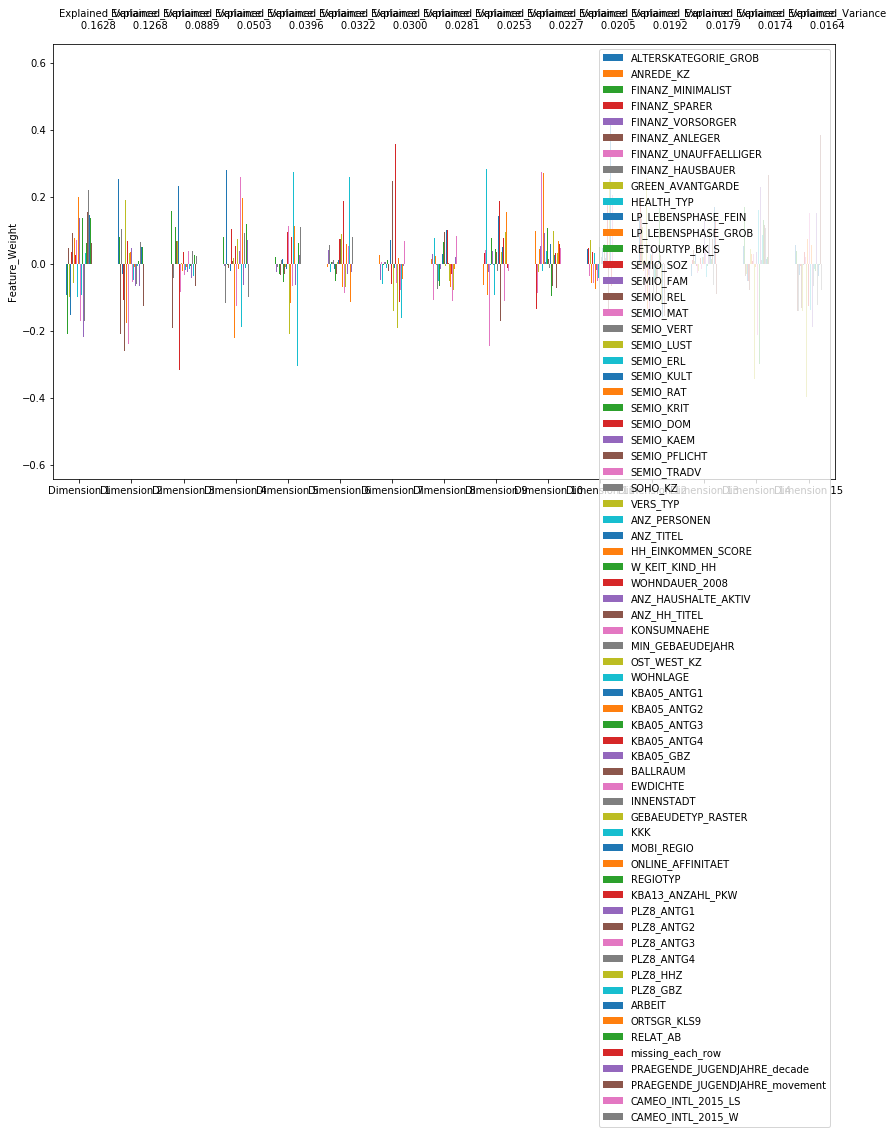

In [70]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca1 = PCA(n_components = 15)

data_pca1 = pca1.fit_transform(azdias_scaler)

pca_results(azdias_scaler, pca1)

In [71]:
#cumulative variance
display(pca1.explained_variance_ratio_.sum())

0.69806579082255693

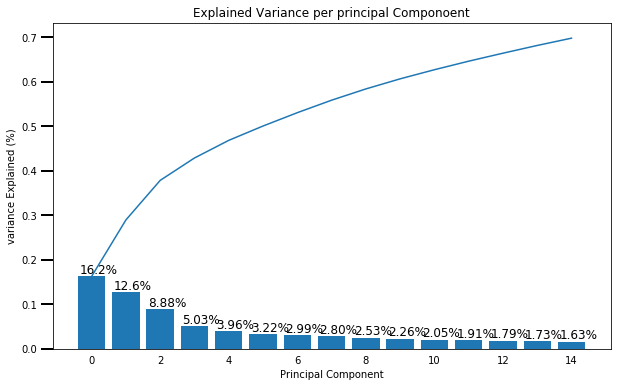

In [72]:
scree_plot(pca1)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)


I applied PCA on the data. at first I chose 34 components and visualized the results. then I reduced it to 15 components. and checked the ratio of variance by each principal component. component 15 gave me 1.63% 

the cumulative variance gave me 69.8% 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [73]:
df_components = pd.DataFrame(pca1.components_)
df_components.columns = azdias_scaler.columns
display(df_components)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_each_row,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_LS,CAMEO_INTL_2015_W
0,-0.091268,0.009957,-0.209175,0.125104,-0.094315,0.048285,0.056589,0.166113,-0.099553,0.025832,...,0.043924,-0.166140,0.146086,0.203654,0.138217,-0.013568,0.053964,0.061686,-0.119707,0.204183
1,0.255185,0.091575,0.082113,-0.244887,0.241147,-0.207904,-0.227707,0.105678,-0.001817,-0.061680,...,0.009721,-0.051287,0.052546,0.072445,0.051818,-0.022419,-0.242653,-0.125665,0.015673,0.052077
2,0.078494,-0.368927,0.158423,-0.109642,0.104978,-0.190291,-0.101546,-0.041134,0.043534,-0.023437,...,0.002568,-0.034308,0.031533,0.041248,0.028672,-0.020171,-0.088325,-0.064369,-0.006126,0.024812
3,-0.032860,0.023129,0.081642,-0.013559,-0.006662,-0.111390,0.048644,-0.116160,0.308109,0.005492,...,0.092195,-0.011234,0.091484,0.258625,0.118794,-0.029420,0.072052,-0.079904,0.051278,-0.097731
4,0.037295,-0.003908,0.022548,0.000265,-0.023376,0.100509,-0.097509,-0.007116,-0.136218,0.000083,...,-0.331036,-0.303298,0.127874,-0.030229,0.063795,-0.039798,0.026066,0.065100,-0.056057,0.109859
5,0.043715,-0.007073,-0.074846,0.022523,0.042343,0.049993,-0.006762,0.057180,-0.117291,-0.024079,...,0.408381,0.260153,-0.198459,-0.114577,-0.164041,0.006352,-0.024045,0.027125,-0.077315,0.080394
6,-0.009361,0.026113,0.005048,-0.006059,-0.046739,-0.014661,0.005233,-0.010937,0.065056,-0.058224,...,-0.116981,-0.161998,-0.137792,-0.043007,-0.172328,0.152926,-0.006198,-0.057690,0.070517,-0.102888
7,-0.082673,0.014731,-0.078760,-0.001129,0.031480,0.003665,-0.105916,0.201385,0.031965,0.079283,...,-0.077698,0.029238,-0.012438,-0.014068,-0.017165,-0.583740,0.021643,0.007284,0.084706,-0.011331
8,-0.023256,-0.061264,0.070293,0.032236,-0.003476,0.017231,0.042042,-0.189218,-0.011233,0.284049,...,0.094936,0.093913,0.017026,0.156176,0.029130,-0.012593,0.072092,0.111701,-0.019401,-0.054575
9,-0.100705,0.098145,0.039205,-0.133806,0.163001,-0.081065,-0.086486,0.096918,-0.022390,-0.328267,...,0.032385,0.060856,0.063147,0.068426,0.047324,0.061292,-0.251846,-0.202308,0.049265,-0.007030


In [74]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_feat(x, df):
    sorted_df = df.sort_values(df.index[x], axis=1)
    return sorted_df.iloc[[x]]




In [75]:

display(pca_feat(0,df_components))

,MOBI_REGIO,PLZ8_ANTG1,KBA05_ANTG1,KBA05_GBZ,FINANZ_MINIMALIST,KONSUMNAEHE,INNENSTADT,PLZ8_GBZ,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,ARBEIT,KBA05_ANTG4,PLZ8_ANTG2,FINANZ_HAUSBAUER,HH_EINKOMMEN_SCORE,EWDICHTE,ORTSGR_KLS9,CAMEO_INTL_2015_W,PLZ8_ANTG4,PLZ8_ANTG3
0,-0.242568,-0.226238,-0.22182,-0.21645,-0.209175,-0.17101,-0.16843,-0.16614,-0.151454,-0.136887,...,0.146086,0.155249,0.156658,0.166113,0.201165,0.201513,0.203654,0.204183,0.220017,0.227858


In [76]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
display(pca_feat(1,df_components))


,SEMIO_REL,FINANZ_SPARER,PRAEGENDE_JUGENDJAHRE_decade,SEMIO_TRADV,SEMIO_PFLICHT,FINANZ_UNAUFFAELLIGER,SEMIO_KULT,FINANZ_ANLEGER,SEMIO_FAM,SEMIO_RAT,...,ANREDE_KZ,FINANZ_HAUSBAUER,SEMIO_KAEM,SEMIO_KRIT,W_KEIT_KIND_HH,RETOURTYP_BK_S,SEMIO_LUST,SEMIO_ERL,FINANZ_VORSORGER,ALTERSKATEGORIE_GROB
1,-0.25911,-0.244887,-0.242653,-0.238409,-0.234273,-0.227707,-0.225897,-0.207904,-0.189627,-0.175539,...,0.091575,0.105678,0.109749,0.115803,0.12044,0.165208,0.190777,0.237084,0.241147,0.255185


In [77]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

display(pca_feat(2,df_components))

,ANREDE_KZ,SEMIO_KAEM,SEMIO_DOM,SEMIO_KRIT,SEMIO_RAT,FINANZ_ANLEGER,SEMIO_ERL,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,PRAEGENDE_JUGENDJAHRE_decade,...,SEMIO_LUST,ALTERSKATEGORIE_GROB,W_KEIT_KIND_HH,FINANZ_VORSORGER,RETOURTYP_BK_S,FINANZ_MINIMALIST,SEMIO_KULT,SEMIO_FAM,SEMIO_SOZ,SEMIO_VERT
2,-0.368927,-0.338366,-0.315995,-0.276438,-0.22072,-0.190291,-0.173295,-0.109642,-0.101546,-0.088325,...,0.068489,0.078494,0.093024,0.104978,0.110638,0.158423,0.233358,0.248813,0.261134,0.345555


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)


Principal Component #1 features:

Negative: 

MOBI_REGIO: ( Movement Patterns)  

PLZ8_ANTG1: ( number of 1-2 family houses in the PLZ8 region)

KBA05_ANTG1: ( number of 1-2 family houses in the microcell)

Positive: 

PLZ8_ANTG3: (Number of 6-10 family houses in the PLZ8 region)

Principal Component #2 features:

Negative:
SEMIO_REL: (personality typology - religious)

FINANZ_SPARER: (financial typology - money saver)

PRAEGENDE_JUGENDJAHRE_decade: (person's youth in decades)

positive:

ALTERSKATEGORIE_GROB: ( estimated age)

Principal Component #3 features:

Negative:

ANREDE_KZ: (gender)

SEMIO_KAEM: (personal typology, combative attitude)

SEMIO_DOM: (personal typology, dominant-minded)

positive:
SEMIO_VERT: (personal typology, dreamful)


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [78]:
def kmeans_score(data, center):
    kmeans = KMeans(n_clusters=center)
    
    model = kmeans.fit(data)
    
    score = np.abs(model.score(data))
    
    return score

In [79]:
# Over a number of different cluster counts...


# run k-means clustering on the data and...
    
    
# compute the average within-cluster distances.
    
score = []

centers = list(range(1,10))

for center in centers:
    score.append(kmeans_score(data_pca1, center))
    



Text(0.5,1,'number of clusters vs score')

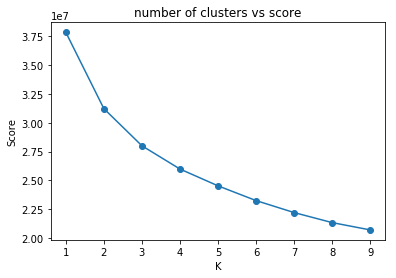

In [80]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(centers, score, marker='o')
plt.xlabel('K')
plt.ylabel('Score')
plt.title('number of clusters vs score')


In [81]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

Kmeans = KMeans(n_clusters = 4)

model = Kmeans.fit(data_pca1)

data_cluster = model.predict(data_pca1)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)


after applied the correlation between number of clusters and scores and computed the average distance between the clusters and the centroids. I have conculated that 4 clusters is the better one because it is further from score and not decressing that much.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [82]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [83]:
display(customers.head(n=5))

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [84]:
display(customers['CAMEO_INTL_2015'])

0          13
1         NaN
2          34
3          24
4          41
5          34
6          23
7          15
8          55
9          15
10        NaN
11         14
12         22
13         43
14         51
15         15
16         15
17         14
18         41
19         24
20         33
21         43
22         24
23         51
24         33
25         22
26         25
27         44
28         54
29         51
         ... 
191622     43
191623     14
191624     54
191625     25
191626     24
191627     55
191628     22
191629     55
191630     51
191631     44
191632     14
191633     14
191634     33
191635     45
191636     34
191637     25
191638     52
191639     22
191640     15
191641     14
191642     55
191643     15
191644     41
191645     43
191646     14
191647     14
191648     32
191649     24
191650     24
191651     33
Name: CAMEO_INTL_2015, Length: 191652, dtype: object

In [85]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customer_data, num_of_record, index, drop_rows, more_than_10 = clean_data(customers)

1


0          13
1         NaN
2          34
3          24
4          41
5          34
6          23
7          15
8          55
9          15
10        NaN
11         14
12         22
13         43
14         51
15         15
16         15
17         14
18         41
19         24
20         33
21         43
22         24
23         51
24         33
25         22
26         25
27         44
28         54
29         51
         ... 
191622     43
191623     14
191624     54
191625     25
191626     24
191627     55
191628     22
191629     55
191630     51
191631     44
191632     14
191633     14
191634     33
191635     45
191636     34
191637     25
191638     52
191639     22
191640     15
191641     14
191642     55
191643     15
191644     41
191645     43
191646     14
191647     14
191648     32
191649     24
191650     24
191651     33
Name: CAMEO_INTL_2015, Length: 191652, dtype: object

2


0          13
1         NaN
2          34
3          24
4          41
5          34
6          23
7          15
8          55
9          15
10        NaN
11         14
12         22
13         43
14         51
15         15
16         15
17         14
18         41
19         24
20         33
21         43
22         24
23         51
24         33
25         22
26         25
27         44
28         54
29         51
         ... 
191622     43
191623     14
191624     54
191625     25
191626     24
191627     55
191628     22
191629     55
191630     51
191631     44
191632     14
191633     14
191634     33
191635     45
191636     34
191637     25
191638     52
191639     22
191640     15
191641     14
191642     55
191643     15
191644     41
191645     43
191646     14
191647     14
191648     32
191649     24
191650     24
191651     33
Name: CAMEO_INTL_2015, Length: 191652, dtype: object

3


0         13
2         34
3         24
4         41
5         34
6         23
7         15
8         55
9         15
11        14
12        22
13        43
14        51
15        15
16        15
17        14
18        41
19        24
20        33
21        43
22        24
23        51
24        33
25        22
26        25
27        44
28        54
29        51
30        32
31        24
          ..
191622    43
191623    14
191624    54
191625    25
191626    24
191627    55
191628    22
191629    55
191630    51
191631    44
191632    14
191633    14
191634    33
191635    45
191636    34
191637    25
191638    52
191639    22
191640    15
191641    14
191642    55
191643    15
191644    41
191645    43
191646    14
191647    14
191648    32
191649    24
191650    24
191651    33
Name: CAMEO_INTL_2015, Length: 141650, dtype: object

In [86]:
display(customer_data['CAMEO_INTL_2015_W'])

0         1.0
2         3.0
3         2.0
4         4.0
5         3.0
6         2.0
7         1.0
8         5.0
9         1.0
11        1.0
12        2.0
13        4.0
14        5.0
15        1.0
16        1.0
17        1.0
18        4.0
19        2.0
20        3.0
21        4.0
22        2.0
23        5.0
24        3.0
25        2.0
26        2.0
27        4.0
28        5.0
29        5.0
30        3.0
31        2.0
         ... 
191622    4.0
191623    1.0
191624    5.0
191625    2.0
191626    2.0
191627    5.0
191628    2.0
191629    5.0
191630    5.0
191631    4.0
191632    1.0
191633    1.0
191634    3.0
191635    4.0
191636    3.0
191637    2.0
191638    5.0
191639    2.0
191640    1.0
191641    1.0
191642    5.0
191643    1.0
191644    4.0
191645    4.0
191646    1.0
191647    1.0
191648    3.0
191649    2.0
191650    2.0
191651    3.0
Name: CAMEO_INTL_2015_W, Length: 141650, dtype: float64

In [87]:
customer_data.insert(loc = 67, column = 'GEBAEUDETYP_5.0', value = 0)

In [88]:
display(customer_data.head(n=5))

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_LS,CAMEO_INTL_2015_W,GEBAEUDETYP_5.0
0,4,1,5,1,5,1,2,2,1,1.0,...,5.0,5.0,1.0,2.0,1.0,30.0,1.0,3.0,1.0,0
2,4,2,5,1,5,1,4,4,1,2.0,...,3.0,2.0,3.0,5.0,3.0,30.0,1.0,4.0,3.0,0
3,4,1,5,1,5,2,1,2,0,2.0,...,3.0,4.0,1.0,3.0,1.0,20.0,0.0,4.0,2.0,0
4,3,1,3,1,4,4,5,2,0,3.0,...,3.0,3.0,3.0,5.0,1.0,60.0,1.0,1.0,4.0,0
5,3,1,5,1,5,1,2,3,1,3.0,...,5.0,5.0,3.0,7.0,5.0,30.0,1.0,4.0,3.0,0


In [89]:
# scaling the data
scaler = StandardScaler()
customer_data_scalling = pd.DataFrame(scaler.fit_transform(customer_data))
customer_data_scalling.columns = customer_data.columns
customer_data_scalling.index = customer_data.index

#customer_data[customer_data.columns] = scaler.transform(customer_data[customer_data.columns].as_matrix())



In [90]:

customer_data_pca = pca1.transform(customer_data_scalling)


In [91]:
customer_predict = model.predict(customer_data_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d49011a90>]], dtype=object)

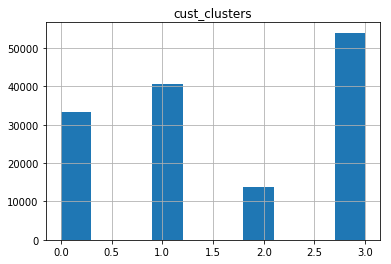

In [92]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.


customer_compare = pd.DataFrame(customer_predict, columns=['cust_clusters'])
customer_compare.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d48f6d668>]], dtype=object)

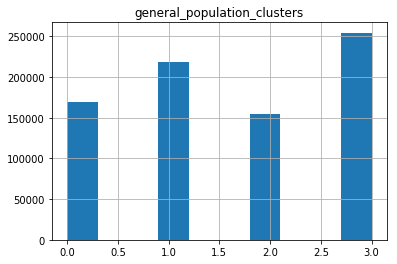

In [93]:

azdias_cust = pd.DataFrame(data_cluster, columns = ['general_population_clusters'])

azdias_cust.hist()

In [94]:
azdias_propability = pd.DataFrame(azdias_cust.general_population_clusters.value_counts())/(new_azdias.shape[0]) *100

azdias_drop_rows = (new_azdias_2[new_azdias_2['missing_each_row'] > 20].shape[0])/(new_azdias.shape[0]) * 100

print(azdias_drop_rows)

#adding dropping rows as a cluster

adding_rows = pd.Series([azdias_drop_rows], index = ['general_population_clusters'])

azdias_propability = azdias_propability.append(adding_rows, ignore_index = True)

azdias_propability.sort_index(inplace = True)

display(azdias_propability)

print(azdias_propability.sum())


10.508280213325314


,general_population_clusters
0,28.550494
1,24.574152
2,19.062836
3,17.304238
4,10.508280


general_population_clusters    100.0
dtype: float64


In [95]:
customers_propability = pd.DataFrame(customer_compare.cust_clusters.value_counts())/(num_of_record) *100

add_cluster = (drop_rows/(num_of_record)) * 100

print(add_cluster)

#adding dropping rows as a cluster

adding_rows = pd.Series([add_cluster], index = ['cust_clusters'])

customers_propability = customers_propability.append(adding_rows, ignore_index = True)

customers_propability.sort_index(inplace = True)

display(customers_propability)

print(customers_propability.sum())


26.089996451902408


,cust_clusters
0,28.167721
1,21.157097
2,17.424290
3,7.160896
4,26.089996


cust_clusters    100.0
dtype: float64


In [96]:
# restore indices for general population

azdias_clust = pd.DataFrame (data_cluster, columns = ['clusters'])
azdias_clust.index = azdias_scaler.index
display(azdias_clust.tail(n=10))

,clusters
891211,1
891212,1
891213,3
891214,2
891215,2
891216,0
891217,1
891218,0
891219,2
891220,1


In [97]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?


display(pd.DataFrame(more_than_10.median()).transpose()) # it is for the data that have more than 20% of missing data

/opt/conda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:986: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,2.0,6.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.5,3.0


In [98]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

azdias_under = azdias_1.join(azdias_clust)
display(azdias_under.head(n=5))

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_each_row,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_LS,CAMEO_INTL_2015_W,clusters
1,1,2,1,5,2,5,4,5,0,3.0,...,4.0,3.0,5.0,4.0,0,90.0,1.0,1.0,5.0,2
2,3,2,1,4,1,2,3,5,1,3.0,...,4.0,3.0,5.0,2.0,0,90.0,0.0,4.0,2.0,3
3,4,2,4,2,5,2,1,2,0,2.0,...,4.0,2.0,3.0,3.0,7,60.0,1.0,2.0,1.0,3
4,3,1,4,3,4,1,3,2,0,3.0,...,3.0,4.0,6.0,5.0,0,60.0,1.0,3.0,4.0,1
5,1,2,3,1,5,2,2,5,0,3.0,...,5.0,2.0,3.0,3.0,0,30.0,0.0,4.0,5.0,0


In [99]:
azdias_under_1 = azdias_under[azdias_under['clusters'] == 3]
display(azdias_under_1.head(n=5))

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_each_row,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_LS,CAMEO_INTL_2015_W,clusters
2,3,2,1,4,1,2,3,5,1,3.0,...,4.0,3.0,5.0,2.0,0,90.0,0.0,4.0,2.0,3
3,4,2,4,2,5,2,1,2,0,2.0,...,4.0,2.0,3.0,3.0,7,60.0,1.0,2.0,1.0,3
8,3,1,4,4,2,4,2,2,1,3.0,...,3.0,2.0,4.0,3.0,0,80.0,0.0,3.0,1.0,3
9,3,2,2,4,2,3,5,4,1,2.0,...,3.0,2.0,3.0,1.0,0,90.0,0.0,5.0,1.0,3
12,3,1,5,3,4,2,4,1,0,1.0,...,5.0,3.0,6.0,4.0,6,60.0,1.0,3.0,4.0,3


In [100]:
display(pd.DataFrame(azdias_under_1.median()).transpose())

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_each_row,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_LS,CAMEO_INTL_2015_W,clusters
0,3.0,1.0,5.0,1.0,4.0,2.0,2.0,2.0,0.0,2.0,...,4.0,3.0,4.0,3.0,0.0,60.0,0.0,4.0,2.0,3.0


### Discussion 3.3: Compare Customer Data to Demographics Data


the results below can give us some ideas about overrepresented and underrepresented customers:

# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?


ALTERSKATEGORIE_GROB: 2.0 ( estimated age: 30 - 45 years old)

ANREDE_KZ: 2.0 ( gender: female)

CJT_GESAMTTYP: 6.0 ( Advertising- Enthusiast with restricted Cross-Channel-Behaviour)

FINANZ_MINIMALIST: 3.0 ( low financial interest - average)

FINANZ_SPARER: 4.0 (money-saver: low)


# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# cluster == 3

ALTERSKATEGORIE_GROB: 3.0 ( estimated age: 46 - 60 years old)

ANREDE_KZ: 1.0 ( gender: male)

FINANZ_MINIMALIST: 5.0 ( low financial interest - very low)

FINANZ_SPARER: 1.0 (money-saver: very high)

FINANZ_VORSORGER: 4.0 (be prepared: low)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.